# ⚙️Process Data: Load, Visualize and Transform the DataSet for the needs of the DBN model

In [1]:
import os
import glob
import numpy as np
from utils.utils import group_weekly
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings('ignore')

#### Dynamic Bayesian Network Model: <br/>
SurfacePressure -> Wind, Temperature, Migration <br/>
Wind -> Humidity, CloudCoverage <br/>
Temperature -> Humidity, CloudCoverage, NDVI <br/>
Humidity -> Rain, NDVI <br/>
CloudCoverage -> Rain, NDVI <br/>
Rain -> NDVI <br/>
Longitude -> Temperature, Wind, SurfacePressure <br/>
Latitude -> Temperature, Wind, SurfacePressure <br/>
NDVI -> Migration <br/>

### 🔹Load and concatenate data

In [2]:
concatenated_df = pd.DataFrame()

# Iterate over files in the folder
for file_path in glob.glob(os.path.join('data', 'StorkMigrationWithNDVIWeather*.csv')):
    print(file_path)
    data = pd.read_csv(file_path)
    if 'Unnamed: 0' in data.columns:
        data = data.drop(['Unnamed: 0'],axis=1)
    data['timestamp'] = pd.to_datetime(data['timestamp'])
    result_data = group_weekly(data)
    concatenated_df = pd.concat([concatenated_df, result_data])

print(concatenated_df.shape)
concatenated_df.to_csv(os.path.join('data','GrouppedByData.csv'))
print('Csv file created')
concatenated_df['timestamp']=pd.to_datetime(concatenated_df['timestamp'])
concatenated_df = concatenated_df.dropna()
copy_concatenated_df = concatenated_df.copy()

data\StorkMigrationWithNDVIWeather-10.csv
data\StorkMigrationWithNDVIWeather-11.csv
data\StorkMigrationWithNDVIWeather-12.csv
data\StorkMigrationWithNDVIWeather-13.csv
data\StorkMigrationWithNDVIWeather-14.csv
data\StorkMigrationWithNDVIWeather-15.csv
data\StorkMigrationWithNDVIWeather-16.csv
data\StorkMigrationWithNDVIWeather-17.csv
data\StorkMigrationWithNDVIWeather-18.csv
data\StorkMigrationWithNDVIWeather-19.csv
data\StorkMigrationWithNDVIWeather-2.csv
data\StorkMigrationWithNDVIWeather-20.csv
data\StorkMigrationWithNDVIWeather-21.csv
data\StorkMigrationWithNDVIWeather-22.csv
data\StorkMigrationWithNDVIWeather-23.csv
data\StorkMigrationWithNDVIWeather-24.csv
data\StorkMigrationWithNDVIWeather-25.csv
data\StorkMigrationWithNDVIWeather-26.csv
data\StorkMigrationWithNDVIWeather-27.csv
data\StorkMigrationWithNDVIWeather-28.csv
data\StorkMigrationWithNDVIWeather-29.csv
data\StorkMigrationWithNDVIWeather-3.csv
data\StorkMigrationWithNDVIWeather-30.csv
data\StorkMigrationWithNDVIWeather-3

In [51]:
concatenated_df = copy_concatenated_df.copy()
display(concatenated_df.head())

,tag-local-identifier,timestamp,NDVI,temperature_2m,relative_humidity_2m,rain,surface_pressure,cloud_cover,wind_speed_100m,distance-flown,location-lat,location-long,distance-traveled
1,2301,2014-04-07,1.000000,27.166506,75.406218,0.0,1012.119917,19.424948,17.504099,190.006150,52.939327,11.787121,80.332094
2,2301,2014-04-14,1.000000,27.296474,72.291403,0.0,1013.621793,5.509615,9.664323,8.633323,52.939315,11.787140,0.001848
3,2301,2015-01-26,0.311800,7.368060,31.763185,0.0,912.871041,1.088406,15.018297,4867.366319,11.628961,25.130908,4734.574226
4,2301,2015-02-02,0.276642,10.896092,30.919514,0.0,915.741864,5.623704,17.692069,935.171770,11.499063,24.830863,35.742784
5,2301,2015-02-09,0.189800,16.451284,18.642753,0.0,929.048683,4.644090,21.572337,1119.210112,11.238312,27.654547,309.548916


In [52]:
result = concatenated_df.groupby('tag-local-identifier').agg({'timestamp': ['count', 'min', 'max']}).reset_index()

# Rename columns for clarity
result.columns = ['value', 'count', 'min_timestamp', 'max_timestamp']

display(result)

,value,count,min_timestamp,max_timestamp
0,1787,7,2013-03-11,2013-04-22
1,1791,28,2013-03-11,2015-04-20
2,1793,28,2013-03-11,2015-04-13
3,1794,17,2013-03-11,2014-04-14
4,1796,18,2013-03-11,2014-04-07
5,1797,20,2014-02-10,2015-04-13
6,2301,41,2013-03-11,2016-04-11
7,2303,9,2013-03-11,2013-05-06
8,2305,18,2013-03-11,2014-04-07
9,2306,37,2013-03-11,2016-04-11


### Data Discretization

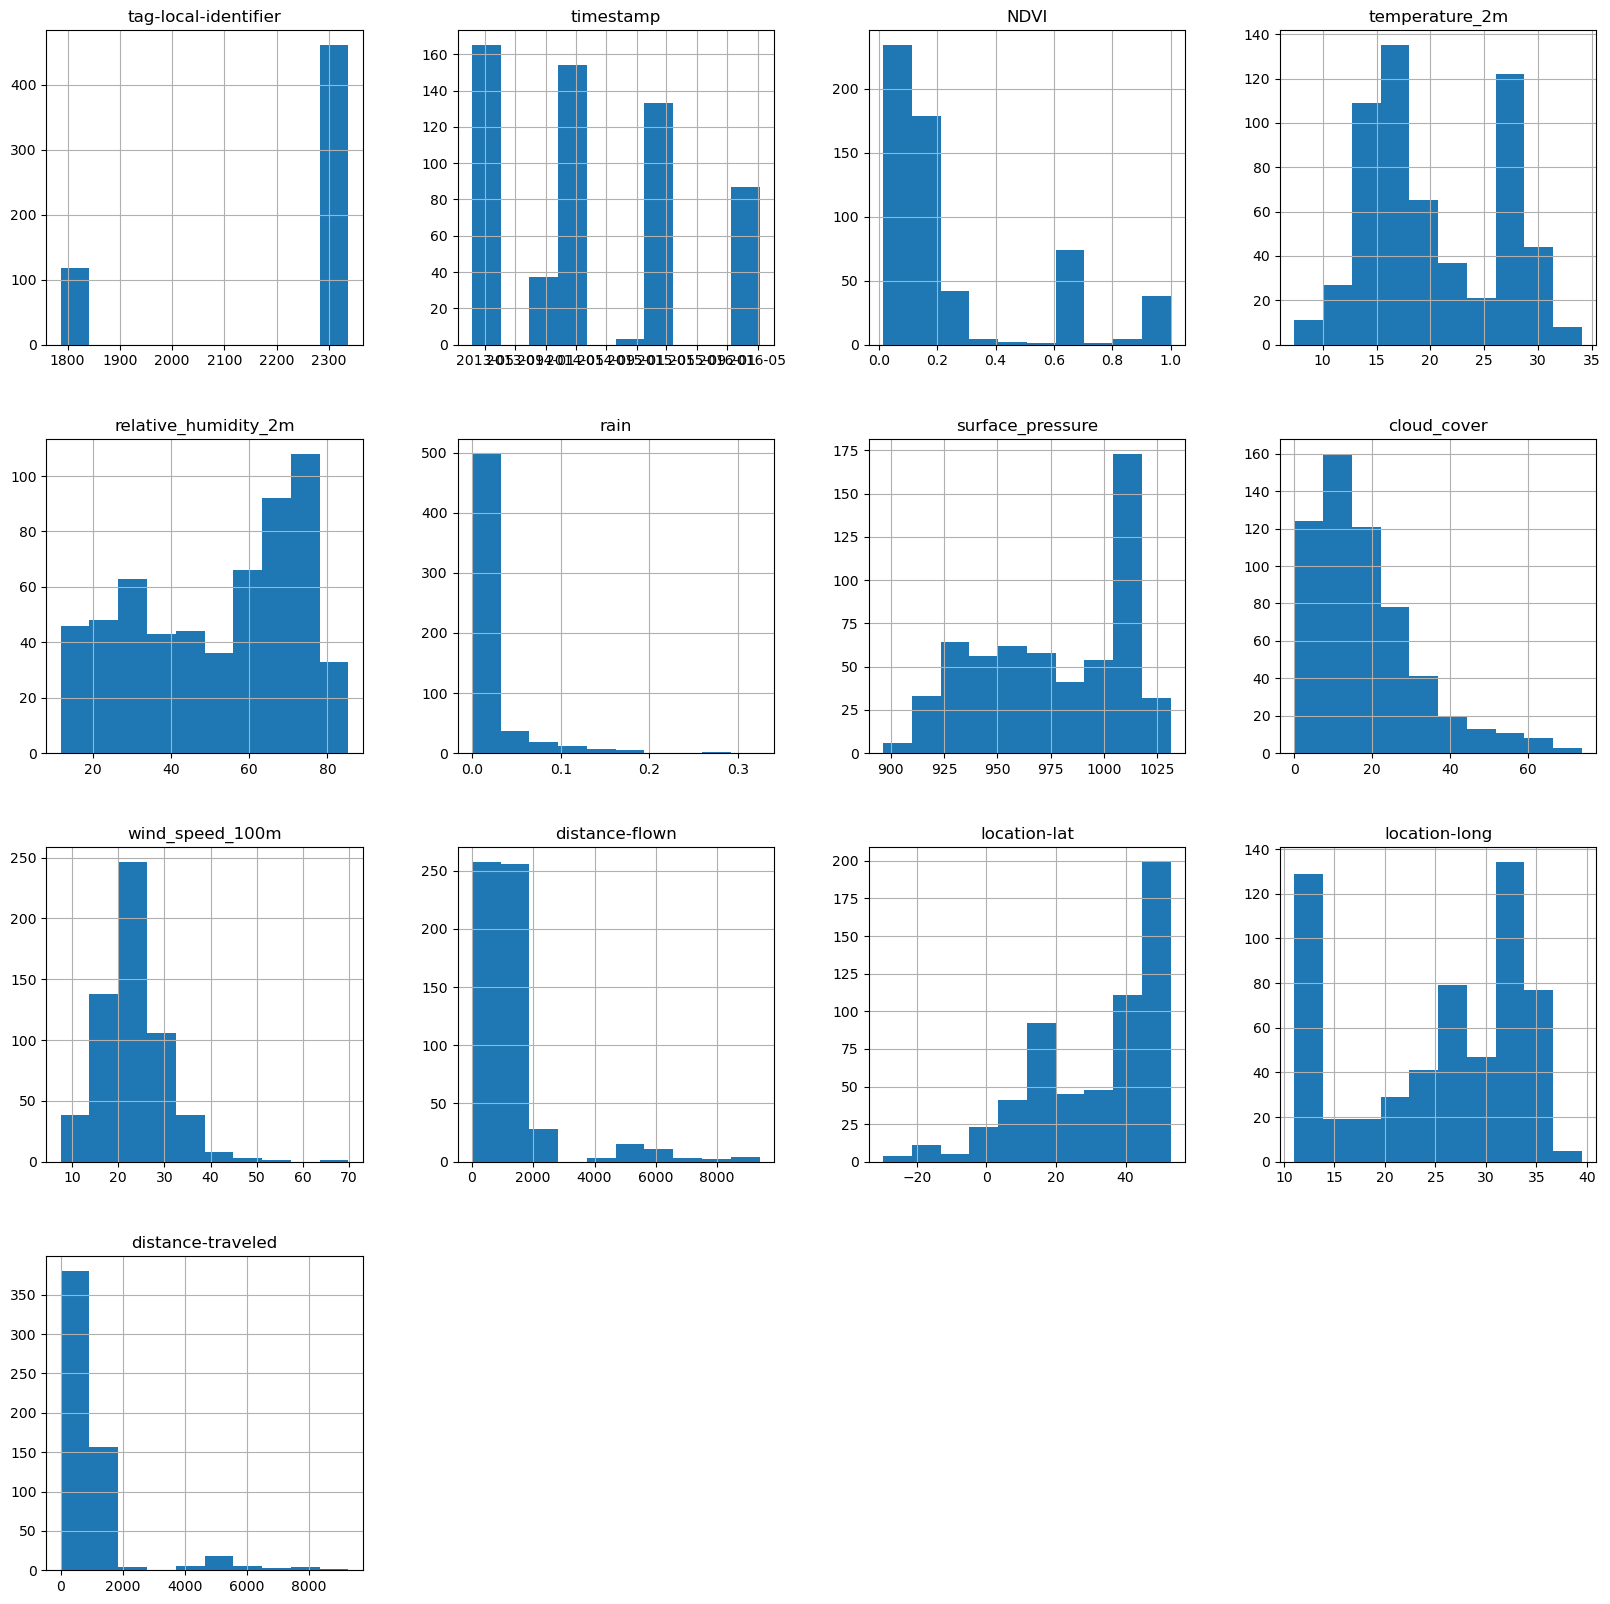

In [53]:
concatenated_df.hist(figsize=(20,20))
plt.show()

Explain dropped columns and why

In [54]:
concatenated_df = copy_concatenated_df.copy()
print(concatenated_df.columns)

Index(['tag-local-identifier', 'timestamp', 'NDVI', 'temperature_2m',
       'relative_humidity_2m', 'rain', 'surface_pressure', 'cloud_cover',
       'wind_speed_100m', 'distance-flown', 'location-lat', 'location-long',
       'distance-traveled'],
      dtype='object')


In [55]:
concatenated_df = concatenated_df.drop(['distance-flown'],axis=1)
new_column_names = ['Stork_id', 'Timestamp', 'NDVI', 'Temperature', 'RelativeHumidity', 'Rain', 'SurfacePressure', 'CloudCover', 'WindSpeed',
                    'LastLatitude', 'LastLongitude','Migrating']
concatenated_df.columns = new_column_names
concatenated_df = concatenated_df.round(4)
display(concatenated_df.head())
print(concatenated_df.shape)

,Stork_id,Timestamp,NDVI,Temperature,RelativeHumidity,Rain,SurfacePressure,CloudCover,WindSpeed,LastLatitude,LastLongitude,Migrating
1,2301,2014-04-07,1.0000,27.1665,75.4062,0.0,1012.1199,19.4249,17.5041,52.9393,11.7871,80.3321
2,2301,2014-04-14,1.0000,27.2965,72.2914,0.0,1013.6218,5.5096,9.6643,52.9393,11.7871,0.0018
3,2301,2015-01-26,0.3118,7.3681,31.7632,0.0,912.8710,1.0884,15.0183,11.6290,25.1309,4734.5742
4,2301,2015-02-02,0.2766,10.8961,30.9195,0.0,915.7419,5.6237,17.6921,11.4991,24.8309,35.7428
5,2301,2015-02-09,0.1898,16.4513,18.6428,0.0,929.0487,4.6441,21.5723,11.2383,27.6545,309.5489


(579, 12)


In [56]:
# concatenated_df is assumed to be defined elsewhere in your code

# Specify the columns you want to discretize
columns_to_discretize = [ 'NDVI', 'Temperature', 'RelativeHumidity', 'Rain', 'SurfacePressure', 'CloudCover', 'WindSpeed','Migrating']
# Specify the number of bin
number_of_bins = [2,3,2,2,2,2,2,2]

# Reset the index of concatenated_df to avoid duplicate index values
concatenated_df.reset_index(drop=True, inplace=True)

bin_names_dictionary = dict()

# Sort DataFrame by the column you are discretizing
for i in range(0,len(columns_to_discretize)):
    column = columns_to_discretize[i]
    num_bins = number_of_bins[i]
    bin_names_dictionary[column] = {}
    
    # Sort DataFrame by the column
    df_sorted = concatenated_df.sort_values(by=column)
    
    # Discretize values into bins with equal number of records
    discretized_column, bin_edges = pd.qcut(df_sorted[column], q=num_bins, labels=False, duplicates='drop', retbins=True)

    # Create a DataFrame containing the discretized values and bin edges
    result_table = pd.DataFrame({
        'Bin_edge_low_' + column: bin_edges[:-1],
        'Bin_edge_high_' + column: bin_edges[1:]
    })  # Use the same index as the sorted DataFrame

    precision = 2
    if column =='Rain':
        precision = 6
    for ind,row in result_table[:-1].iterrows():
        bin_names_dictionary[column][ind]=f'< {round(row[f"Bin_edge_high_" + column],precision)}'
    bin_names_dictionary[column][ind]=f'> {round(result_table.iloc[-1][f"Bin_edge_low_" + column],precision)}'
    # Write dictionary string to a text file
    with open(os.path.join('data','Labels_dictionary_for discretization.txt'), 'w') as file:
        file.write(str(bin_names_dictionary))
    display(result_table)
    
    # Merge result_table with the original DataFrame to retain other columns
    concatenated_df[column] = discretized_column


display(concatenated_df.head())
print(concatenated_df.shape)

,Bin_edge_low_NDVI,Bin_edge_high_NDVI
0,0.0149,0.1674
1,0.1674,1.0000


,Bin_edge_low_Temperature,Bin_edge_high_Temperature
0,7.368100,16.145167
1,16.145167,23.779167
2,23.779167,34.090000


,Bin_edge_low_RelativeHumidity,Bin_edge_high_RelativeHumidity
0,11.7135,56.9539
1,56.9539,85.3342


,Bin_edge_low_Rain,Bin_edge_high_Rain
0,0.0000,0.0018
1,0.0018,0.3240


,Bin_edge_low_SurfacePressure,Bin_edge_high_SurfacePressure
0,896.3911,979.4087
1,979.4087,1031.3650


,Bin_edge_low_CloudCover,Bin_edge_high_CloudCover
0,0.0000,15.0941
1,15.0941,73.9728


,Bin_edge_low_WindSpeed,Bin_edge_high_WindSpeed
0,7.5055,22.6739
1,22.6739,69.8538


,Bin_edge_low_Migrating,Bin_edge_high_Migrating
0,0.0011,708.8944
1,708.8944,9269.3923


,Stork_id,Timestamp,NDVI,Temperature,RelativeHumidity,Rain,SurfacePressure,CloudCover,WindSpeed,LastLatitude,LastLongitude,Migrating
0,2301,2014-04-07,1,2,1,0,1,1,0,52.9393,11.7871,0
1,2301,2014-04-14,1,2,1,0,1,0,0,52.9393,11.7871,0
2,2301,2015-01-26,1,0,0,0,0,0,0,11.6290,25.1309,1
3,2301,2015-02-02,1,0,0,0,0,0,0,11.4991,24.8309,0
4,2301,2015-02-09,1,1,0,0,0,0,0,11.2383,27.6545,0


(579, 12)


In [57]:
display(bin_names_dictionary)

{'NDVI': {0: '> 0.17'},
 'Temperature': {0: '< 16.15', 1: '> 23.78'},
 'RelativeHumidity': {0: '> 56.95'},
 'Rain': {0: '> 0.0018'},
 'SurfacePressure': {0: '> 979.41'},
 'CloudCover': {0: '> 15.09'},
 'WindSpeed': {0: '> 22.67'},
 'Migrating': {0: '> 708.89'}}

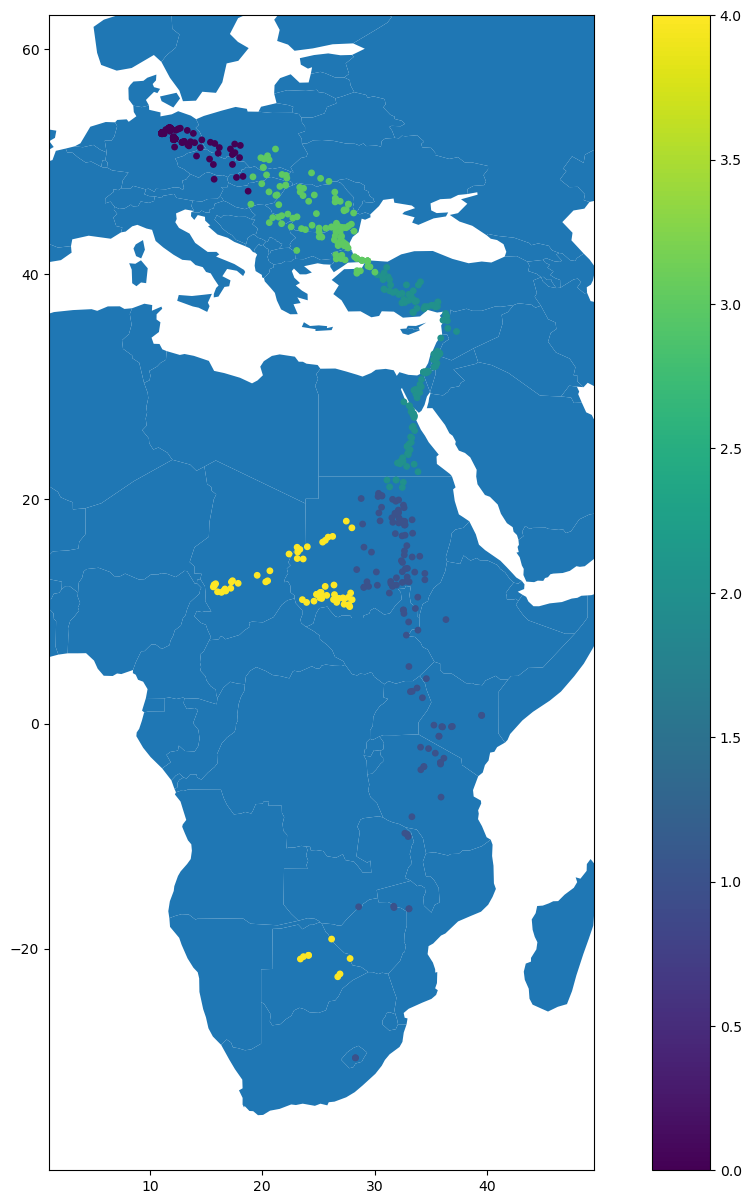

In [58]:
# Extract latitude and longitude columns
X = concatenated_df[['LastLatitude', 'LastLongitude']]

# Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply K-means clustering
kmeans = KMeans(n_clusters=5)  # You can change the number of clusters as needed
kmeans.fit(X_scaled)

# Assign cluster labels
concatenated_df['Region'] = kmeans.labels_

# Load world map data
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Convert latitude and longitude to Point objects
geometry = [Point(x,y) for x,y in zip(concatenated_df['LastLongitude'], concatenated_df['LastLatitude'])]

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(concatenated_df, geometry=geometry)


# Plot the world map
fig, ax = plt.subplots(figsize=(15, 15))
world.plot(ax=ax)

# Plot the clusters on the world map
gdf.plot(column='Region', cmap='viridis', legend=True, ax=plt.gca(),s=15)
plt.xlim(gdf['LastLongitude'].min() - 10, gdf['LastLongitude'].max() + 10)
plt.ylim(gdf['LastLatitude'].min() - 10, gdf['LastLatitude'].max() + 10)

plt.show()


In [59]:
concatenated_df = concatenated_df.drop(['LastLatitude','LastLongitude'],axis=1)
display(concatenated_df.head())
print(concatenated_df.shape)

,Stork_id,Timestamp,NDVI,Temperature,RelativeHumidity,Rain,SurfacePressure,CloudCover,WindSpeed,Migrating,Region
0,2301,2014-04-07,1,2,1,0,1,1,0,0,0
1,2301,2014-04-14,1,2,1,0,1,0,0,0,0
2,2301,2015-01-26,1,0,0,0,0,0,0,1,4
3,2301,2015-02-02,1,0,0,0,0,0,0,0,4
4,2301,2015-02-09,1,1,0,0,0,0,0,0,4


(579, 11)


### Transform for Dynamic Bayesian Network (DBN)

Insert type of format needed

In [60]:
# r_input_entries=[]
# for id in selected_ids:
#     subdata = concatenated_df[concatenated_df['Stork_id']==id]
#     subdata = subdata.drop(['Stork_id','Timestamp'],axis=1)
#     flattened_subdata = subdata.stack().reset_index(drop=True).to_frame().T
#     display(flattened_subdata)
#     r_input_entries.append(flattened_subdata.values.tolist()[0])
#     print(flattened_subdata.values.tolist()[0])

# min_length = min(len(inner_list) for inner_list in r_input_entries)
# trimmed_lists = [inner_list[:min_length] for inner_list in r_input_entries]

In [61]:
input_data_for_NB = []

for stork_id in concatenated_df['Stork_id'].unique().tolist():
    subdata = concatenated_df[concatenated_df['Stork_id']==stork_id]
    subdata['Timestamp'] = pd.to_datetime(subdata['Timestamp'])

    # Create a new column 'order' containing the ordered indices
    #subdata['Order'] = subdata['Timestamp'].rank(method='first').astype(int) - 1

    # Sort DataFrame by 'timestamp_column'
    subdata = subdata.sort_values(by='Timestamp')

    # Reset index to maintain consistency (optional)
    subdata = subdata.drop(['Timestamp','Stork_id'],axis=1)
    subdata = subdata.reset_index(drop=True)
    #display(subdata.head())
    
    flattened_data = subdata.apply(lambda row: ','.join(map(str, row)), axis=1)
    flattened_data = flattened_data.str.split(',').apply(lambda x: [int(i) for i in x])
    #display(flattened_data)

    # Concatenate all the lists into a single list
    result = sum(flattened_data, [])
    
    input_data_for_NB.append(result)
input_data_for_NB_df = pd.DataFrame({'Timeseries': input_data_for_NB})
display(input_data_for_NB_df.head())
input_data_for_NB_df.to_csv(os.path.join('data',f'DBN_input_data.csv'),sep=';')
print(input_data_for_NB_df.shape)
print(f'Data stored to csv')

,Timeseries
0,"[0, 0, 1, 0, 1, 0, 1, 0, 2, 0, 1, 0, 1, 0, 0, ..."
1,"[0, 2, 0, 0, 0, 0, 0, 0, 4, 0, 2, 0, 0, 0, 0, ..."
2,"[0, 1, 1, 1, 1, 1, 1, 1, 2, 0, 1, 1, 1, 1, 1, ..."
3,"[0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, ..."
4,"[0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, ..."


(24, 1)
Data stored to csv
